#  ELEC-E5500 Speech Processing -- Autumn 2023  

###  Exercise 2: Fundamental frequency estimation.

## Instructions: 

(1) Implement and return files as Exercise_2_yourfirstname.ipynb along with your speech file. Remember to answer the written questions within the file! 

(2) In this exercise, you will record your own speech file. Record the speech signal as "my name is XX and I am doing the second exercise", (where, XX --> your name) then store the file as "yourfirstname.wav".

(3) Return your answers to MyCourses by 23:59 on Monday, September 18th, 2023.

## In this exercise, you will be implementing two functions. They are,

(1) F0_autocorr --> Function for $F0$ estimation using the autocorrelation method.

(2) F0_cepstrum --> Function for $F0$ estimation using the cepstral method.

Expected plots are provided at the end of the notebook for you to check your code output (i.e., to know the intended solution). Your solutions will not be identical as you will be using your own speech file. 

## Introduction

 In this exercise we implement functions for a basic speech signal processing task: Fundamental frequency ($F0$) estimation. The two most common basic approaches to $F0$ estimation from speech are the autocorrelation method and the cepstral method. Both of these methods operate under the stationarity assumption of the speech signal. Moreover, since we want to determine the pitch period, the frame length should include at least two pitch periods (ideally three) of the speech speaker. These requirements can be hard to match ideally in the case of low-pitched male speech.

## Import all the required packages

In [1]:
import scipy.io.wavfile as wav
import scipy.signal as sig
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
from scipy.io import wavfile
import matplotlib.pyplot as plt
import sounddevice as sd

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
fs = 16000  # Sample rate/sampling frequency
seconds = 5  # Duration of recording

# Record 5 seconds of your speech (i.e,, my name is XX)
data = sd.rec(int(seconds * fs), samplerate=fs, channels=1)
sd.wait()  # Wait until recording is finished

In [ ]:
filename = 'Mohammad_ex2.wav'
wavfile.write(filename, fs, data)

# remove data, such that we can read it again
del data

# Let's start Excercise 2

In [ ]:
# NOTE: Check the amplitude values of 'data' (as they depend on the audio package to read the signal). 
# Example: Scipy wav.read reads wav files as 16 bit integers from -32768 to 32767. 
# We need to transform the values in the range from -1 to 1. This will avoid further normalization problems.

# if type(data[0]) == np.int16:
#    data = np.divide(data,32768,dtype=np.float32)

# Make sure the sampling rate is 16 kHz. If not, resample to 16 kHz.

In [2]:
# Read the audio file and sampling rate

Fs, data = wav.read('Mohammad_ex2.wav')

Fs_target = 16000

#Scipy wav.read reads wav files as 16 bit integers from -32768 to 32767. We need to transform it into floats from -1 to 1.
if type(data[0]) == np.int16:
    data = np.divide(data,32768,dtype=np.float32)
# 1.2. Make sure the sampling rate is 16kHz. Resample if not 16kHz

if not (Fs == Fs_target):
    data = sig.resample_poly(data,Fs_target,Fs)
    Fs = Fs_target

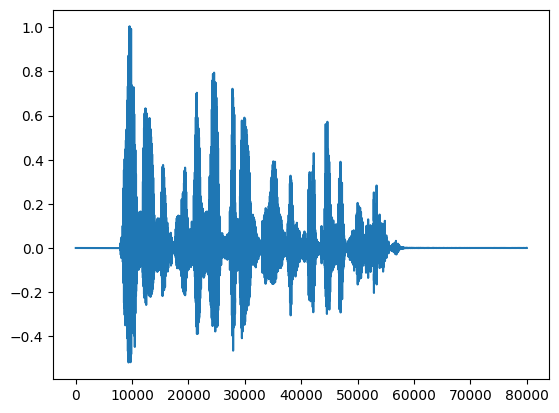

In [3]:
#data=data/max(abs(data))
plt.plot(data)

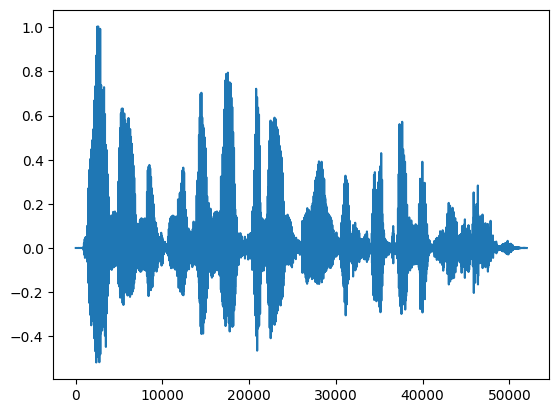

In [4]:
# you might want to trim the data, if you have silence or noise at the intial region and/or end region
start_index = 7000
end_index = 59000
data1=data[start_index:end_index]
plt.plot(data1)

In [5]:
data=data1;

In [6]:
frame_length_ms = 50 # in miliseconds
hop_length_ms = 12.5 # in miliseconds

frame_length = int(np.around((frame_length_ms/1000)*Fs))# 50ms in samples
hop_size = int(np.around((hop_length_ms/1000)*Fs))# 12.5 ms in samples (12.5/50 % overlap)
window_types = ('rect','hann','cosine','hamming') # window types

# Windowing of speech

In [7]:
# Split the data sequence into windows. 

def windowing_function(data, frame_length, hop_size, windowing_function):
    data = np.array(data)
    number_of_frames = 1+int(np.floor((len(data)-frame_length)/hop_size))
    frame_matrix = np.zeros((frame_length,number_of_frames))

    if windowing_function == 'rect':
        window = np.ones((frame_length,1))
    elif windowing_function == 'hann':
        window = np.hanning(frame_length)
    elif windowing_function == 'cosine':
        window = np.sqrt(np.hanning(frame_length))
    elif windowing_function == 'hamming':
        window = np.hamming(frame_length)
    else:
        os.error('Windowing function not supported')

        
    for i in range(number_of_frames):
        start = i*hop_size
        stop = np.minimum(start+frame_length,len(data))

        frame = np.zeros(frame_length)

        frame[0:stop-start] = data[start:stop]
        frame_matrix[:,i] = np.multiply(window,frame)
    return frame_matrix

In [8]:
frame_matrix = windowing_function(data, frame_length, hop_size, window_types[3])# Windowing

In [9]:
frame_matrix.shape

(800, 257)

## Autocorrelation method 
The autocorrelation sequence $r[k]$ with maximum a lag of $K$ samples of a signal $s[n]$ whose length is $N$ is defined as:
\begin{equation}
 r[k] = \sum_{n=k}^{N-1}s[n]s[n-k], \qquad 0 \leq k \leq K
\label{eq:ac}
\end{equation}






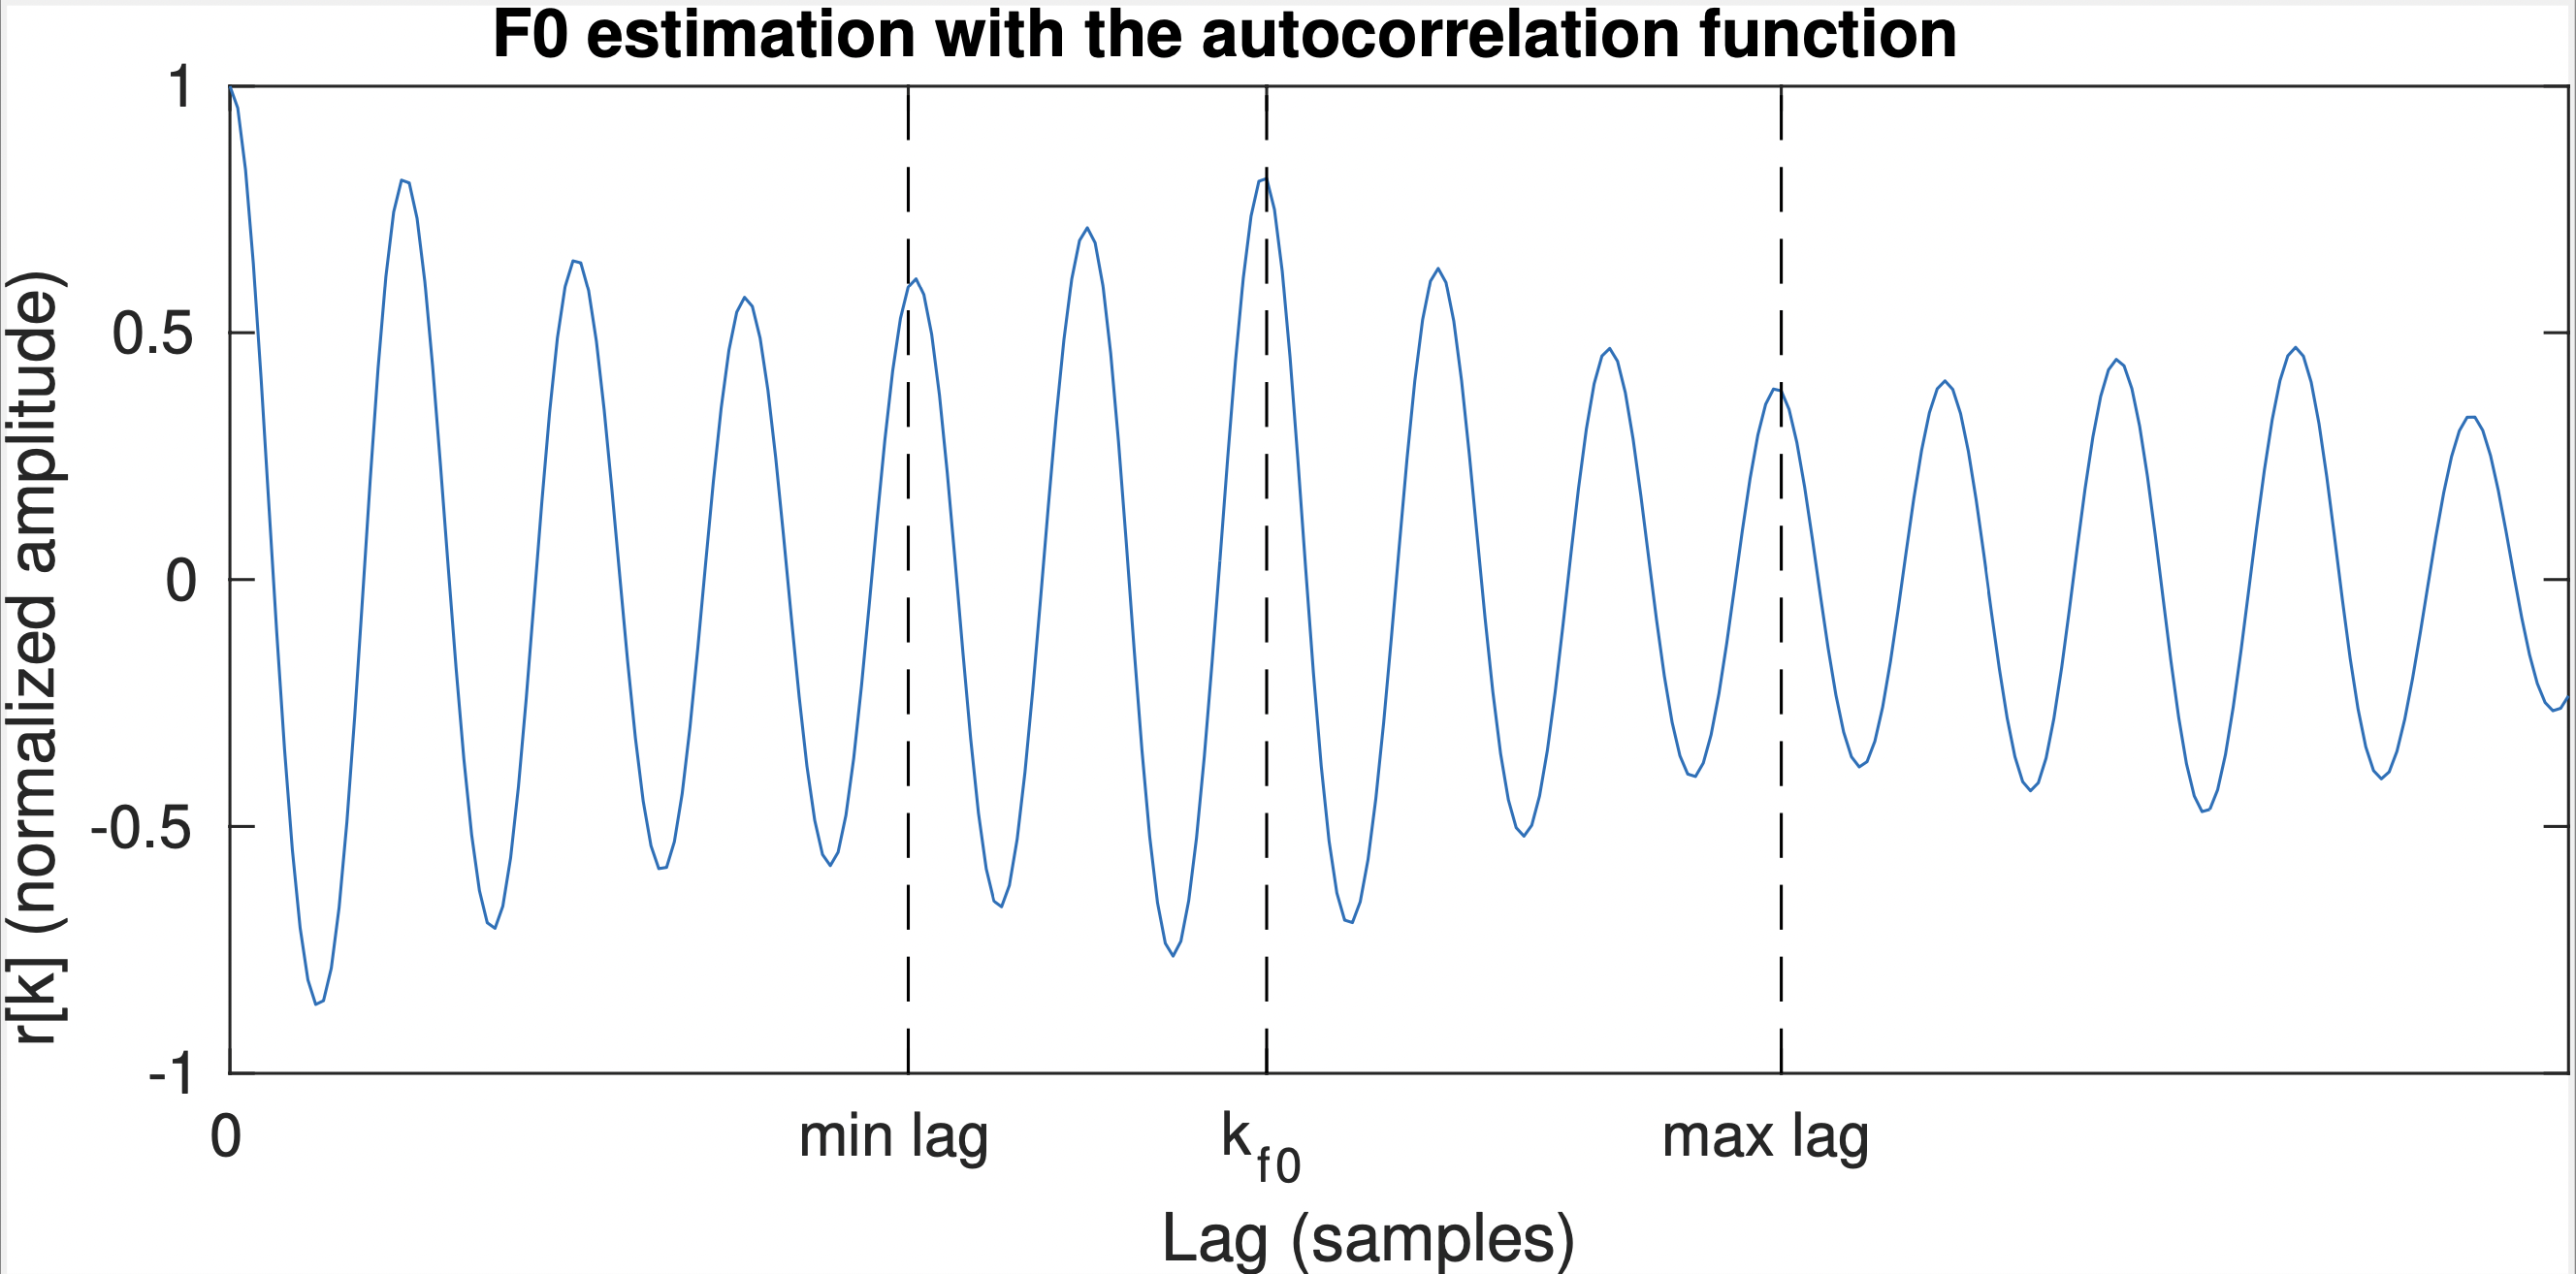
Figure shows the $F_0$ estimation using the autocorrelation method.




The autocorrelation function computes the correlation of the signal with itself at a given lag $k$. If within the sum of above equation the contributions of the positive values are greater than the negative values, the autocorrelation coefficient for that lag value is positive (and vice versa). For a (quasi) periodic signal, the term inside the sum should be positive at the multiples of $T_0 = \frac{1}{F_0}$, resulting in a peak positive value ($F_0$ is the fundumental frequency). Thus, a basic $F_0$ estimator can be obtained by peak picking the autocorrelation sequence within a reasonable lag range (e.g., 70-180 Hz for male speech, 100-300 Hz for female speech), and then converting the lag $k_{F_0}$ from samples back into Hz by:
\begin{equation}
 F_0 = \frac{F_s}{k_{F_0}}
\end{equation}
where $F_s$ is the sampling rate (frequency). The relative amplitude of the found autocorrelation peak can be compared to the amplitude of the autocorrelation at zero lag (i.e., signal power) to obtain a crude estimate of the voicing prominence of the frame.

## Useful functions (numpy)

correlate, amax, argmax

## (1) Fundamental frequency (F0) estimation with the autocorrelation method

In [ ]:
# You need to implement 'F0_autocorr' function (below cell) to run this cell 


# 1. Define minimum and maximum values for the F0 search range, and the threshold value for 
# Voiced/Unvoiced decision. 
f0_max = None
f0_min = None
vuv_threshold_ac = None

# 2. Write a loop through frame_matrix that calls the function F0_autocorr to compute
# the F0 estimatation for each frame

f0vec_ac = np.zeros((len(frame_matrix[0]),1)) # Allocate f0 vector for the autocorrelation method
ac_peak_vec = np.zeros((len(frame_matrix[0]),1)) # Allocate vector for ac peak amplitude vector


# 3. You need to implement 'F0_autocorr' function (the cell below)

for iFrame in range(len(frame_matrix[0])):
    f0vec_ac[iFrame], ac_peak_vec[iFrame] = F0_autocorr(frame_matrix[:,iFrame], Fs, f0_min, f0_max, vuv_threshold_ac)

In [ ]:
def F0_autocorr(frame,fs,f0_min,f0_max,vuv_threshold):
    #F0_AUTOCORR Fundamental frequency estimation with the autocorrelation method.
    # Inputs:   'frame': Windowed signal segment
    #           'fs': sampling frequency (sampling rate)
    #           'f0_min' and 'f0_max': Given in Hz, represent the search space for the F0 values          
    #           'vuv_threshold': Heuristic value that acts as a classifier
    #           between voiced and unvoiced frames. A frame is classified as 
    #           unvoiced if the strength of the autocorrelation peak is smaller than vuv_threshold.
    #           
    # Outputs: 'f0': Estimated fundamental frequency (in Hz) for the given speech frame
    #          'ac_peak_val': The amplitude of the autocorrelation peak value

    frame = np.array(frame)
    frame = frame - np.mean(frame) #Remove the mean to omit the effect of DC component
    
    #Number of samples for the lag in calculating the autocorrelation function corresponding to f0_min
    #i.e. maximum length (in samples) for the period to catch the F0 
    max_lag = None #This will be used as an index so you must make sure the variable is an integer
    
    
    #Number of samples for the lag in calculating the autocorrelation function corresponding f0_max
    #i.e. minimum length (in samples) for the period to catch the F0
    min_lag = None #This will be used as an index so you must make sure the variable is an integer

    
    #Compute autocorrelation sequence up in the range [min_lag,max_lag] i.e. from min_lag to max_lag
    r = None

    # Locate the autocorrelation peak and its amplitude between min_lag and max_lag


    if ac_peak_val > vuv_threshold: #Voiced frame
        f0 = None #Compute f0 from obtained lag value
    else: #Unvoiced frame
        f0 = 0

    return f0,ac_peak_val

## Cepstral method

The real cepstrum of a signal $s[n]$ is defined as:

\begin{equation}
  c[m] = \mathcal{F}^{-1}(\log(|\mathcal{F}(s[n])|^2)),
\end{equation}

that is, the inverse discrete Fourier transform of the logarithm of the power spectrum of $s[n]$. Cepstral processing is a homomorphic transform of the underlying signal. For speech, which we assume to be a convolution of an excitation $e[n]$ and filter $f[n]$ within the time domain ($s[n] = e[n]*f[n]$), the convolution can be represented as a product $S(z) = E(z)F(z)$ within the frequency domain. Furthermore, by keeping in mind that $\log |E(z)F(z)|^2  = 2\log{|E(z)|} + 2\log{|F(z)|}$ and that the DFT is a linear operation, we can represent the source-filter separation of the speech signal on the quefrency domain as a sum $c[m] = \mathcal{F}^{-1}(2\log |E(z)|) + \mathcal{F}^{-1}(2\log |F(z)|)$. The quefrency domain has time on its x-axis, but the signal has been transformed so that the fluctuations of the power spectrum are represented at different time lags, identical to ''spectrum of the spectrum'' representation. The slowly varying envelope information of the filter $f[n]$ is packed to the small quefrencies, and the spectral comb structure of the excitation $e[n]$ is represented by a peak at the quefrency corresponding to the length of the fundamental period (in samples).


Thus, similarly to the autocorrelation method, basic $F_0$ estimation within the cepstral domain can be performed by peak picking the quefrency values at lag lengths corresponding to the appropriate $F0$ range. Also, the amplitude of the cepstral peak can be used to crudely estimate the voicing level of the signal.


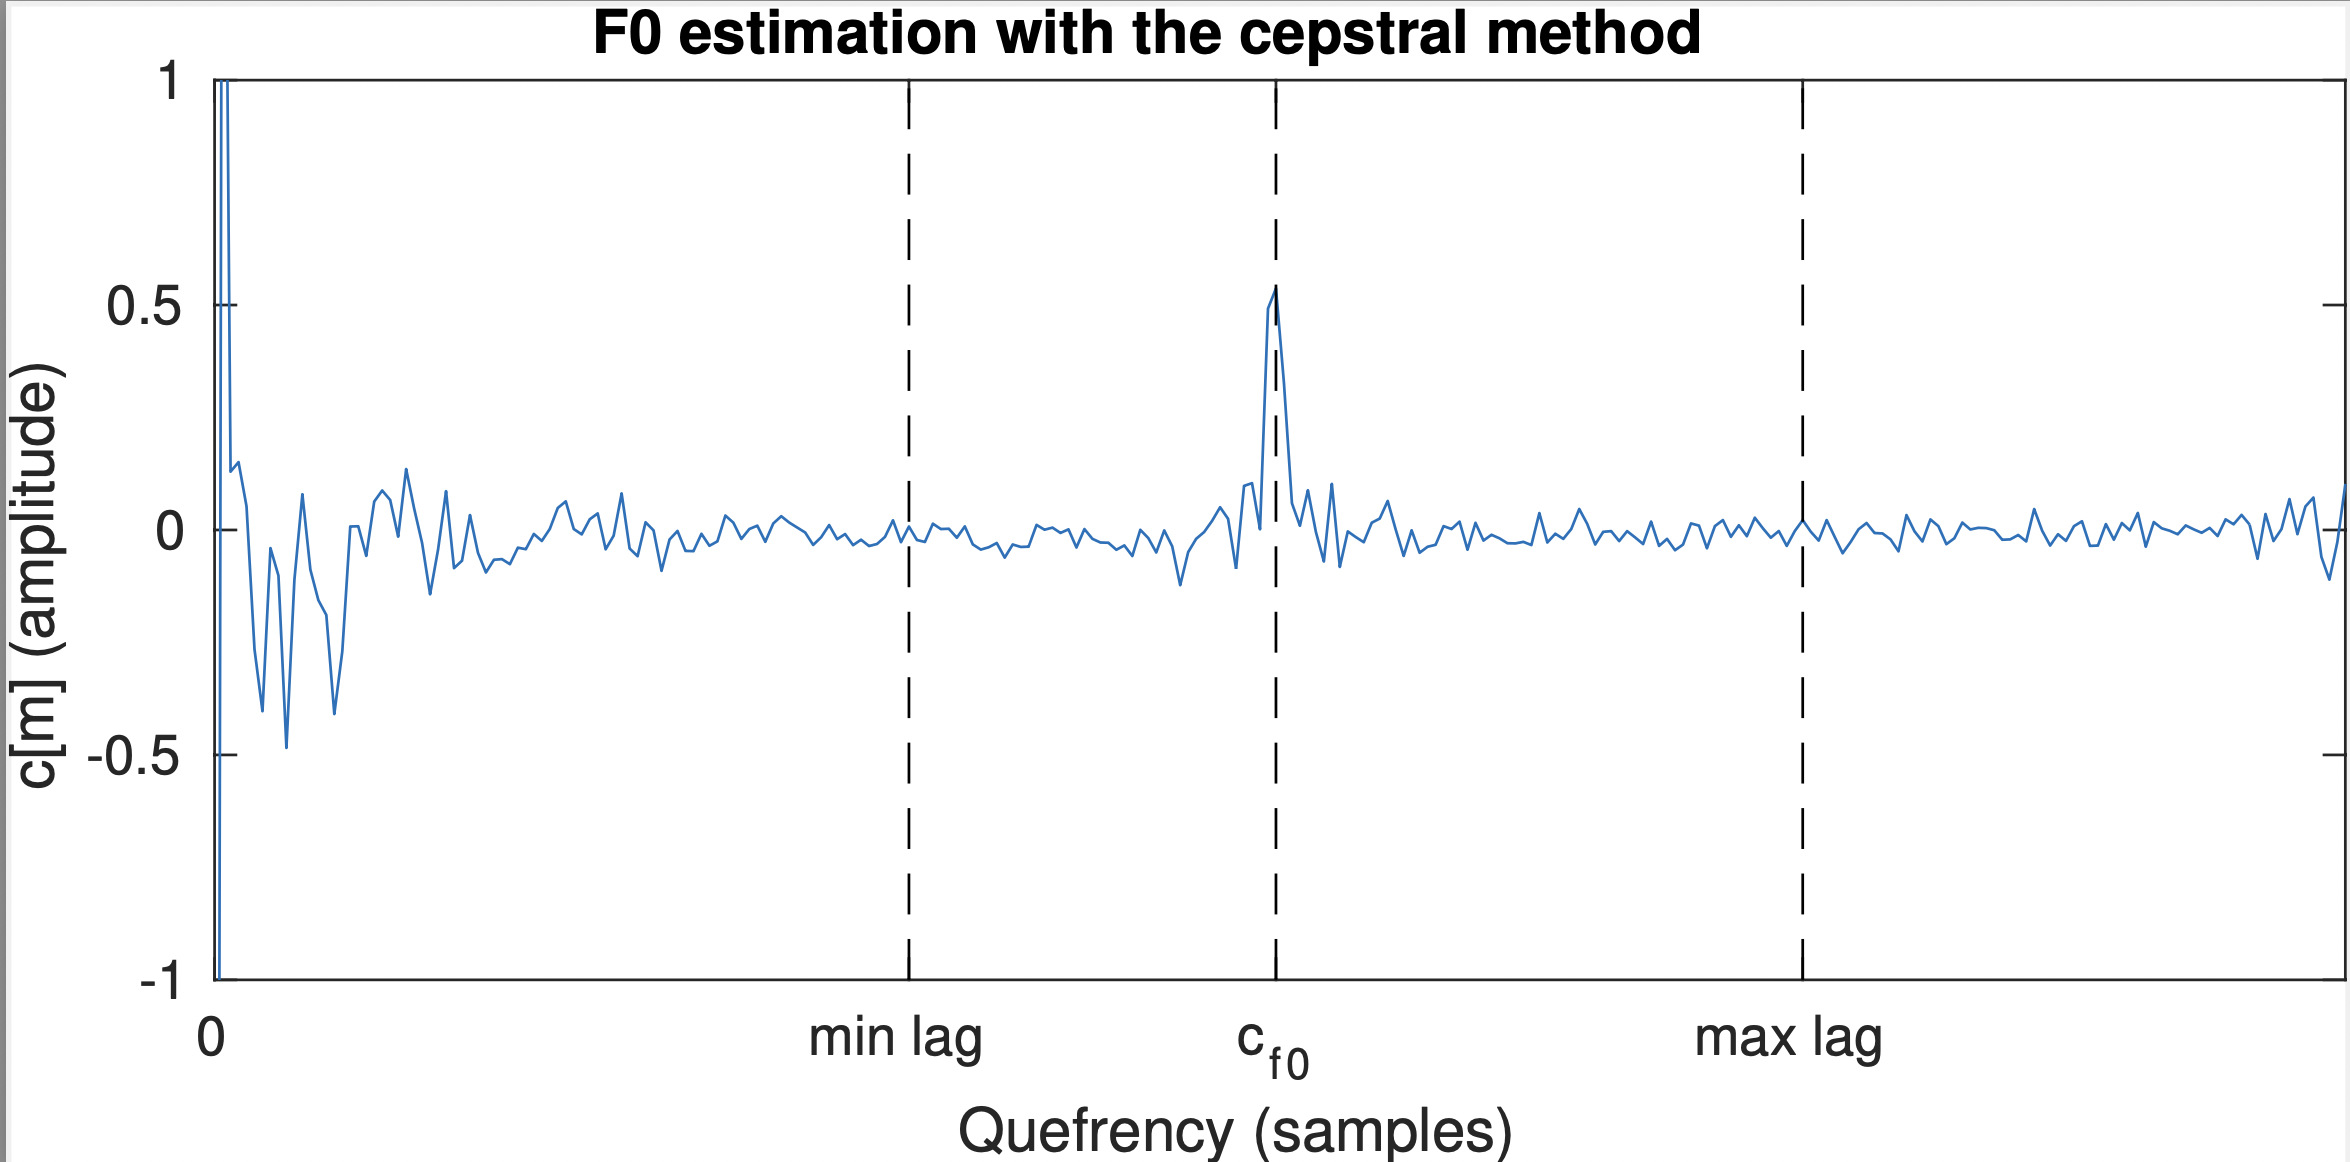
Figure shows the $F_0$ estimation using the cepstral method.


## Useful functions (numpy)

fft, ifft, log10, absolute, real, amax, argmax

# (2) Fundamental frequency estimation with the cepstrum method

In [ ]:
# You need to implement 'F0_cepstrum' function (in the cell below) to run this cell 

# 1. Define the threshold value for Voiced/Unvoiced decision.
vuv_threshold_ceps = None 
f0vec_ceps = np.zeros((len(frame_matrix[0]),1)) # Allocate f0 vector for cepstrum method
ceps_peak_vec = np.zeros((len(frame_matrix[0]),1)) # Allocate vector for cepstral peak vector

# 2. You need to implement 'F0_cepstrum' function (below cell)

for iFrame in range(len(frame_matrix[0])):
    f0vec_ceps[iFrame], ceps_peak_vec[iFrame] = F0_cepstrum(frame_matrix[:,iFrame], Fs, f0_min, f0_max, vuv_threshold_ceps)

In [ ]:
def F0_cepstrum(frame,fs,f0_min,f0_max,vuv_threshold):
    #F0_CEPSTRUM Fundamental frequency estimation with the cepstrum method.
    # Inputs:   'frame': Windowed signal segment
    #           'fs': sampling frequency (sampling rate)
    #           'f0_min' and 'f0_max': Given in Hz, represent the search space for the F0 values.
    #           'vuv_threshold': Heuristic value that acts as a classifier between voiced and unvoiced frames.
    #            A frame is classified as unvoiced if the strength of the cepstral peak is smaller than vuv_threshold.
    #           
    # Outputs:  'f0': Estimated fundamental frequency (in Hz) for the given frame.
    #           'ceps_peak_val': The amplitude of the cepstral peak value.

    frame = np.array(frame)

    #Number of samples for the lag in calculating F0 corresponding to f0_min
    #i.e. maximum length (in samples) for the period to catch the F0 
    max_lag = None #This will be used as an index so you must make sure the variable is an integer
    
    
    #Number of samples for the lag in calculating F0 corresponding to f0_max
    #i.e. minimum length (in samples) for the period to catch the F0
    min_lag = None #This will be used as an index so you must make sure the variable is an integer 

    eps = 0.00001#Add this to the power spectrum to ensure values are above zero (to avoid numerical
                 # issues when using log function)

    #Compute real cepstrum of the frame
    c = None

    #Locate the cepstral peak and its amplitude between min_lag and max_lag

    if cepstral_peak_val > vuv_threshold: #Voiced frame
        f0 = None #Compute f0 from obtained quefrency value
    else: #Unvoiced frame
        f0 = 0

    return f0,cepstral_peak_val

# Illustrations: 

### (1) spectrogram, (2) estimated F0s (autocorrealtion and cepstral methods), and (3) peak amplitudes of the autocorrelation and cepstrum methods.

In [ ]:
# visualize your results
#Nfft = 1024
plt.figure(1)

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 12))
fig.tight_layout()


# Plot the spectrogram of the original signal.
plt.subplot(3,1,1)



# 4.2. Plot the estimated F0 vectors with autocorrelation (ac) and cepstrum (ceps) methods. 
# Report F0max and F0min within the title
plt.subplot(3,1,2)


# 4.3. Plot the peak amplitudes of the cepstral peak and the autocorrelation peak
plt.subplot(3,1,3)







plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show(block=False)

# Questions: experiment with the parameters.

## a) How does tuning these parameters affect the autocorrelation method?
###       i) Frame length
###       ii) Windowing function
###       iii) F0 search range
###       iv) Voicing threshold value

## b) How about the cepstrum method?
###       i) Frame length
###       ii) Windowing function
###       iii) F0 search range
###       iv) Voicing threshold value

In [ ]:
# a)

In [ ]:
# b)

# Write your observations for autocorrelation method here










# Write your observations for cepstral method here












## Expected Result (example)
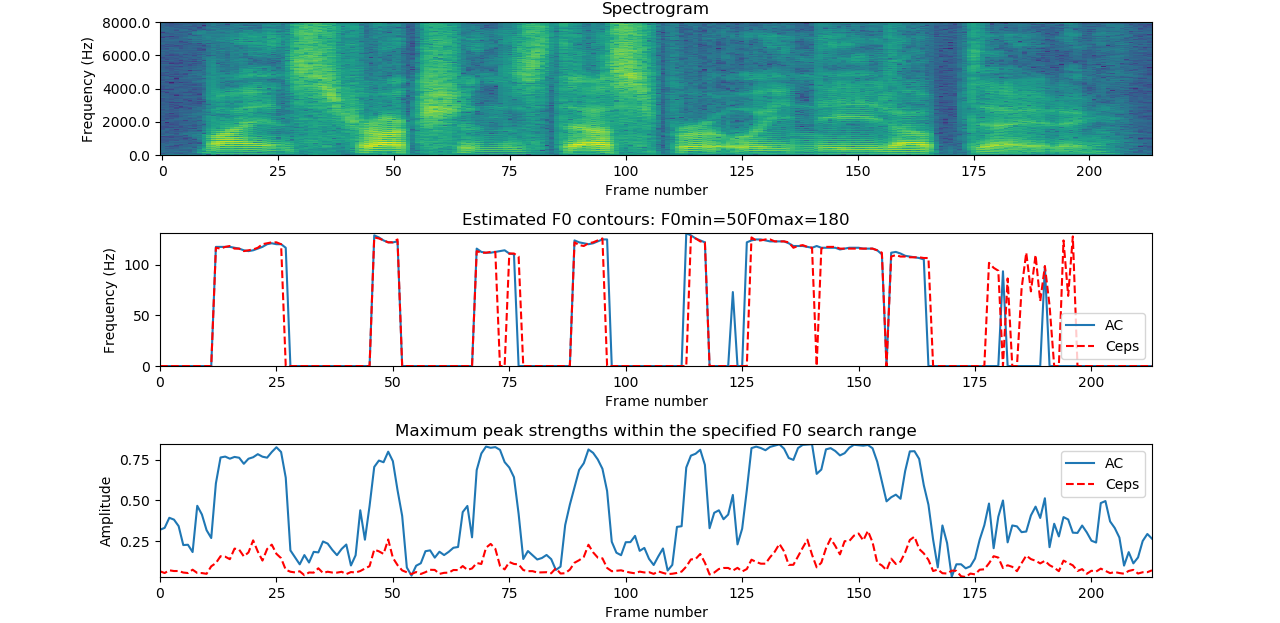